In [ ]:
# @title Install and import necessary packages

# Install vnstock
!pip install vnstock

# Install ta-lib
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
!pip install conda-package-handling
!wget https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
!cph x ta-lib-0.5.1-py311h9ecbd09_0.conda
!mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from collections import defaultdict, Counter
import time

from vnstock import Quote
from talib import abstract, get_functions, get_function_groups

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.linear_model import Lasso
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import pearsonr


In [57]:
# @title OHLCV historical data for HPG (Source: Vietcap Insights)
ticker = 'HPG'
quote = Quote(symbol=ticker, source='VCI')
data = quote.history(start='2008-01-01', end='2025-05-01', interval='1D')
data.set_index('time', inplace=True)

## Visualize
# Candlestick
fig = go.Figure()
fig.add_trace(go.Candlestick(
    x=data.index,
    open=data['open'],
    high=data['high'],
    low=data['low'],
    close=data['close'],
    name='OHLC',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Volume
volume_colors = np.where(data['close'] >= data['open'], 'green', 'red')
fig.add_trace(go.Bar(
    x=data.index,
    y=data['volume'],
    name='Volume',
    marker=dict(
        line=dict(width=0.5, color=volume_colors)
    ),
    yaxis='y2',
    opacity=0.8,
    width=0.8
))

# Layout
fig.update_layout(
    title=dict(
        text=f"<b>Historical OHLCV for {ticker}: 2008–Present</b>",
        x=0.5,
        xanchor='center',
        y=0.9,
        yanchor='top',
        font=dict(size=20)
    ),
    yaxis=dict(title="Price", domain=[0.3, 1]),
    yaxis2=dict(title="Volume", domain=[0, 0.25], anchor='x'),
    height=700,
    xaxis_rangeslider_visible=False,
    showlegend=False
)

fig.show()


It should be noted that although TA-Lib includes a wide range of functions, but only a subset are true "technical indicators" used in trading strategies.

In [58]:
# @title Categories of technical indicators
indicator_groups = ['Cycle Indicators',
                'Momentum Indicators',
                'Overlap Studies',
                'Pattern Recognition',
                'Volatility Indicators',
                'Volume Indicators']
tech_indicators = []

print("📈 TA-Lib Technical Indicators by Group:\n")
for group, names in get_function_groups().items():
    if group in indicator_groups:
        print(f"🟦 {group} ({len(names)} indicators):")
        print("   " + ", ".join(names) + "\n")
        tech_indicators.extend(names)

print(f"✅ Total technical indicators: {len(tech_indicators)}")

📈 TA-Lib Technical Indicators by Group:

🟦 Cycle Indicators (5 indicators):
   HT_DCPERIOD, HT_DCPHASE, HT_PHASOR, HT_SINE, HT_TRENDMODE

🟦 Momentum Indicators (30 indicators):
   ADX, ADXR, APO, AROON, AROONOSC, BOP, CCI, CMO, DX, MACD, MACDEXT, MACDFIX, MFI, MINUS_DI, MINUS_DM, MOM, PLUS_DI, PLUS_DM, PPO, ROC, ROCP, ROCR, ROCR100, RSI, STOCH, STOCHF, STOCHRSI, TRIX, ULTOSC, WILLR

🟦 Overlap Studies (17 indicators):
   BBANDS, DEMA, EMA, HT_TRENDLINE, KAMA, MA, MAMA, MAVP, MIDPOINT, MIDPRICE, SAR, SAREXT, SMA, T3, TEMA, TRIMA, WMA

🟦 Pattern Recognition (61 indicators):
   CDL2CROWS, CDL3BLACKCROWS, CDL3INSIDE, CDL3LINESTRIKE, CDL3OUTSIDE, CDL3STARSINSOUTH, CDL3WHITESOLDIERS, CDLABANDONEDBABY, CDLADVANCEBLOCK, CDLBELTHOLD, CDLBREAKAWAY, CDLCLOSINGMARUBOZU, CDLCONCEALBABYSWALL, CDLCOUNTERATTACK, CDLDARKCLOUDCOVER, CDLDOJI, CDLDOJISTAR, CDLDRAGONFLYDOJI, CDLENGULFING, CDLEVENINGDOJISTAR, CDLEVENINGSTAR, CDLGAPSIDESIDEWHITE, CDLGRAVESTONEDOJI, CDLHAMMER, CDLHANGINGMAN, CDLHARAMI, CDLHARA

In [59]:
#@title Compute all relevant TA-Lib indicators from OHLCV DataFrame
def compute_all_ta(data, tech_indicators):
    data = data.astype(np.float64)
    inputs = {col: data[col].values for col in data.columns}
    result_cols = {}

    for func_name in tech_indicators:
        try:
            func = abstract.Function(func_name)
            if func_name == "MAVP": # MAVP requires declaring an additional variable "period" (type float)
                custom_inputs = inputs.copy()
                custom_inputs['periods'] = np.full(inputs['close'].shape, 20.0, dtype=np.float64)
                out = func(custom_inputs)
            else:
                out = func(inputs)

            if isinstance(out, pd.DataFrame):
                for col in out.columns:
                    result_cols[f"{func_name}_{col}"] = out[col]
            elif isinstance(out, (list, tuple)):
                for i, series in enumerate(out):
                    result_cols[f"{func_name}_{i}"] = pd.Series(series, index=data.index)
            else:
                result_cols[func_name] = pd.Series(out, index=data.index)

        except Exception as e:
            print(f"Skipped {func_name}: {e}")

    df_out = pd.concat([data, pd.DataFrame(result_cols)], axis=1)
    return df_out


data_ta = compute_all_ta(data, tech_indicators)

# Summary of TA features added
print(f"✅ Data shape: {data_ta.shape}")
print(f"📊 Number of new features added: {data_ta.shape[1] - data.shape[1]}")

✅ Data shape: (4318, 139)
📊 Number of new features added: 134


Because TA-Lib functions like MACD, BBANDS, STOCH, etc. return multiple related outputs, we see 134 added features (excluding the original OHLCV series) instead of 119 as expected. For example:

| Indicator | Outputs                    | Signal Meaning                               |
| --------- | -------------------------- | -------------------------------------------- |
| MACD      | `macd`, `signal`, `hist`   | Crossovers between `macd` & `signal` → trend |
| BBANDS    | `upper`, `middle`, `lower` | Price crossing bands → volatility breakouts  |
| STOCH     | `slowk`, `slowd`           | %K crosses %D → momentum shift               |


In [60]:
#@title TA functions with multiple outputs
def multiple_ta_output(data, func_name):
    data = data.astype(np.float64)
    inputs = {col: data[col].values for col in data.columns}
    try:
        func = abstract.Function(func_name)
        out = func(inputs)

        if isinstance(out, (list, tuple)):
            output_names = func.info['output_names']
            print(f"{func_name}: {', '.join(output_names)}")
    except Exception as e:
        pass  # Suppress errors for cleaner output

for func_name in get_functions():
    multiple_ta_output(data_ta, func_name)

HT_PHASOR: inphase, quadrature
HT_SINE: sine, leadsine
MINMAX: min, max
MINMAXINDEX: minidx, maxidx
AROON: aroondown, aroonup
MACD: macd, macdsignal, macdhist
MACDEXT: macd, macdsignal, macdhist
MACDFIX: macd, macdsignal, macdhist
STOCH: slowk, slowd
STOCHF: fastk, fastd
STOCHRSI: fastk, fastd
BBANDS: upperband, middleband, lowerband
MAMA: mama, fama


In these cases, the meaningful trading signal arises from how the outputs interact with each other, rather than from any single output alone. Instead of inputting all raw outputs into the model, we derive key interaction-based features that better capture the underlying signal. The table below outlines these engineered features along with their rationale:


| Feature           | Indicator  | Definition                                  | Rationale                                                             |
|------------------|------------|---------------------------------------------|----------------------------------------------------------------------|
| macd_cross        | MACD       | 1 if MACD > signal line                     | Signals bullish momentum shift (MACD crossover)                     |
| macd_diff         | MACD       | MACD line - signal line                     | Magnitude of momentum shift (strength of crossover)                 |
| bb_width          | BBANDS     | Upper band - Lower band                     | Volatility measure (band expansion during high volatility)          |
| bb_percent        | BBANDS     | (Close - Lower) / (Upper - Lower)          | Position of price within bands (mean reversion likelihood)          |
| bb_breakout       | BBANDS     | 1 if Close > Upper band                     | Potential breakout signal (price exceeds volatility envelope)       |
| stoch_cross       | STOCH      | 1 if %K > %D                                | Momentum reversal (bullish crossover)                               |
| stoch_diff        | STOCH      | %K - %D                                     | Strength of stochastic crossover                                    |
| mama_cross        | MAMA       | 1 if MAMA > FAMA                            | Adaptive trend confirmation (cross above smoothed line)             |
| mama_diff         | MAMA       | MAMA - FAMA                                 | Trend strength (adaptive difference)                                |
| aroon_diff        | AROON      | AroonUp - AroonDown                         | Trend direction and strength (positive → uptrend)                   |
| stochrsi_cross    | STOCHRSI   | 1 if fastK > fastD                          | Momentum reversal based on RSI position                             |


In [61]:
#@title Function to engineer new features: add_derived_features(df)
def add_derived_features(df):
    # MACD cross and difference
    if all(col in df.columns for col in ['MACD_macd', 'MACD_macdsignal']):
        df['MACD_cross'] = (df['MACD_macd'] > df['MACD_macdsignal']).astype(int)
        df['MACD_diff'] = df['MACD_macd'] - df['MACD_macdsignal']
        df.drop(['MACD_macd', 'MACD_macdsignal', 'MACD_macdhist'], axis=1, inplace=True, errors='ignore')

    # BBANDS breakout and width
    if all(col in df.columns for col in ['BBANDS_upperband', 'BBANDS_middleband', 'BBANDS_lowerband', 'close']):
        df['BBANDS_width'] = df['BBANDS_upperband'] - df['BBANDS_lowerband']
        df['BBANDS_percent'] = (df['close'] - df['BBANDS_lowerband']) / df['bb_width']
        df['BBANDS_breakout'] = (df['close'] > df['BBANDS_upperband']).astype(int)
        df.drop(['BBANDS_upperband', 'BBANDS_middleband', 'BBANDS_lowerband'], axis=1, inplace=True, errors='ignore')

    # STOCH crossover
    if all(col in df.columns for col in ['STOCH_slowk', 'STOCH_slowd']):
        df['STOCH_cross'] = (df['STOCH_slowk'] > df['STOCH_slowd']).astype(int)
        df['STOCH_diff'] = df['STOCH_slowk'] - df['STOCH_slowd']
        df.drop(['STOCH_slowk', 'STOCH_slowd'], axis=1, inplace=True, errors='ignore')

    # MAMA crossover
    if all(col in df.columns for col in ['MAMA_mama', 'MAMA_fama']):
        df['MAMA_cross'] = (df['MAMA_mama'] > df['MAMA_fama']).astype(int)
        df['MAMA_diff'] = df['MAMA_mama'] - df['MAMA_fama']
        df.drop(['MAMA_mama', 'MAMA_fama'], axis=1, inplace=True, errors='ignore')

    # AROON trend strength
    if all(col in df.columns for col in ['AROON_aroonup', 'AROON_aroondown']):
        df['AROON_diff'] = df['AROON_aroonup'] - df['AROON_aroondown']
        df.drop(['AROON_aroonup', 'AROON_aroondown'], axis=1, inplace=True, errors='ignore')

    # STOCHRSI crossover
    if all(col in df.columns for col in ['STOCHRSI_fastk', 'STOCHRSI_fastd']):
        df['STOCHRSI_cross'] = (df['STOCHRSI_fastk'] > df['STOCHRSI_fastd']).astype(int)
        df.drop(['STOCHRSI_fastk', 'STOCHRSI_fastd'], axis=1, inplace=True, errors='ignore')

    return df

df = add_derived_features(data_ta)

Some technical indicators or derived features (especially binary ones like crossovers or candlestick patterns) can:

* Have missing values at the beginning of the series (due to the formulas to calculate technical indicators)
* Constant (e.g., all 0s or 1s)
* Flat over long time periods, offering little signal for modeling

We specify a threshold for removing low-variance indicators (99.0% the same value) and also remove the rows with missing values.


🔍 Top columns by % missing:
TRIX            0.020380
TEMA            0.020148
HT_SINE_0       0.014590
HT_SINE_1       0.014590
HT_TRENDLINE    0.014590
HT_DCPHASE      0.014590
DEMA            0.013432
ADXR            0.009264
MACDEXT_1       0.007642
MACD_2          0.007642
dtype: float64


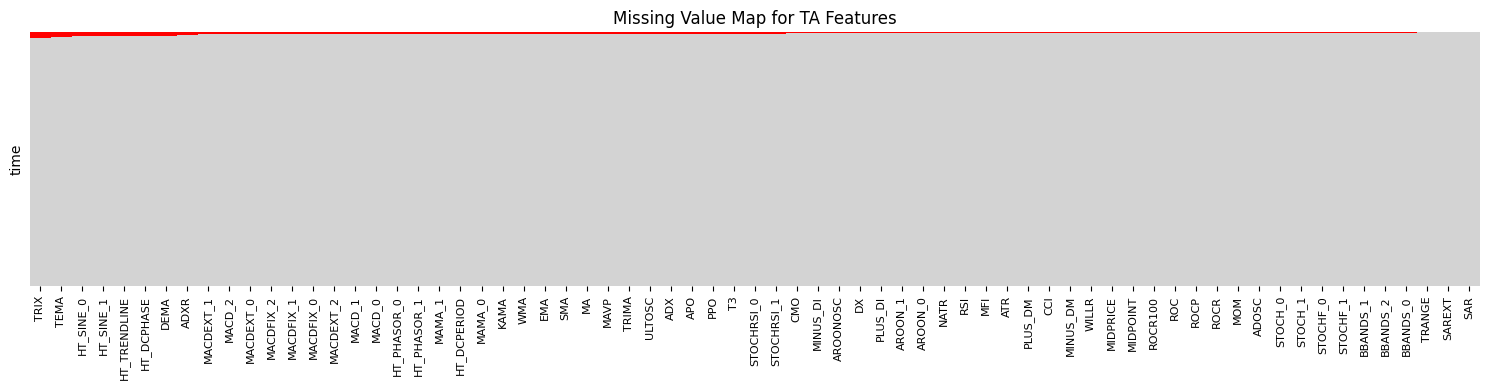

⚠️ Features with ≥ 99% identical values:
CDL3STARSINSOUTH       1.000000
CDLKICKING             1.000000
CDLKICKINGBYLENGTH     1.000000
CDLCONCEALBABYSWALL    1.000000
CDLABANDONEDBABY       1.000000
CDLRISEFALL3METHODS    1.000000
CDLUPSIDEGAP2CROWS     1.000000
CDLMATHOLD             1.000000
CDLBREAKAWAY           0.999768
CDLUNIQUE3RIVER        0.999768
CDLLADDERBOTTOM        0.999537
CDL2CROWS              0.999537
CDL3BLACKCROWS         0.999305
CDL3LINESTRIKE         0.999305
CDL3WHITESOLDIERS      0.999074
CDLMORNINGDOJISTAR     0.999074
CDLHIKKAKEMOD          0.999074
CDLSTICKSANDWICH       0.998842
CDLTASUKIGAP           0.998842
CDLIDENTICAL3CROWS     0.998842
CDLXSIDEGAP3METHODS    0.998610
CDLEVENINGDOJISTAR     0.997684
CDLPIERCING            0.997453
CDLSTALLEDPATTERN      0.997453
CDLDARKCLOUDCOVER      0.997221
CDLTRISTAR             0.997221
CDLMORNINGSTAR         0.996989
CDLADVANCEBLOCK        0.996526
CDLGAPSIDESIDEWHITE    0.996526
CDLEVENINGSTAR         0.996063

In [62]:
#@title Cleansing data: remove missing values and drop low-variance features
# Check missing values
missing = df.isna().mean().sort_values(ascending=False)
print("\n🔍 Top columns by % missing:")
print(missing[missing > 0].head(10))

# Missing value time map
na_cols = missing[missing > 0].index.tolist()
plt.figure(figsize=(min(0.3 * len(na_cols), 15), 4))
sns.heatmap(df[na_cols].isna(),
            cmap=["#d3d3d3", "red"],
            cbar=False,
            yticklabels=False)

plt.title("Missing Value Map for TA Features", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

# Detect low-variance indicators
low_variance_threshold = 0.99
low_var = df.apply(lambda s: s.value_counts(normalize=True, dropna=False).iloc[0])
low_var = low_var[low_var >= low_variance_threshold]
low_var_cols = low_var.index

print(f"⚠️ Features with ≥ {int(low_variance_threshold*100)}% identical values:")
low_var = low_var.sort_values(ascending=False)
print(low_var)
print('\n\n')

# Drop rows with any missing values
original_shape = df.shape
df.dropna(inplace=True)
print(f"🧼 Dropped {original_shape[0] - df.shape[0]} rows with missing values")

# Drop low-variance columns (≥99% same value)
df.drop(columns=low_var_cols, inplace=True)
print(f"🧹 Dropped {len(low_var_cols)} low-variance features (≥99% identical values)")
print(f"✅ Updated data shape: {data_ta.shape}")

Given the large number of predictors—many likely to be highly correlated—we apply a multi-method feature selection ensemble to reduce dimensionality and remove irrelevant or redundant variables (Sagaceta-Mejía et al., 2024). The methods considered include:

**1. Descriptive-statistic-based methods**: Explore inherent feature behavior without fitting any model.

- *Low Variance Filter*: Removes features with little variation across samples, assuming they carry less information.
- *Pearson Correlation*: Excludes features highly correlated with others to avoid redundancy.
- *Chi-Squared Test*: Evaluates dependence between each feature and the target variable for classification tasks.
- *Dispersion Ratio (DR)*: Selects features based on the ratio of between-class to within-class variance.
- *Mean Absolute Difference (MAD)*: Picks features with the highest average absolute deviation.

**2. Model-based feature selection methods**: Involve supervised fitting and penalize or select features based on their predictive contribution.

- *Least Absolute Shrinkage and Selection Operator (LASSO)*: Shrinks less important coefficients to zero via regularization.
- *Tree-Based Feature Selection*: Uses decision tree models to rank features based on their importance in splitting nodes.
- *Principal Feature Analysis (PFA)*: Selects a subset of features that best represent the principal components of the data.

For each feature selection method, the top 25% (i.e., first quartile) of features were retained. A final subset, **Selected(n)**, was then constructed by selecting features that appeared in at least **n** of these method-specific sets. This refined subset was used as input to the predictive model.


In [63]:
# @title Multi-method feature selection ensemble

# --- FEATURE SELECTION METHODS ---
# Collection of diverse feature selection techniques returning top k% features
# Each method handles its own required preprocessing/scaling internally

def low_variance(X, top_k_ratio=0.25):
    """Selects features with highest variance after standardization"""
    X_scaled = StandardScaler().fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    variances = X_scaled.var()
    k = int(top_k_ratio * len(variances))
    return list(variances.sort_values(ascending=False).head(k).index)

def chi_squared(X, y, top_k_ratio=0.25):
    """Chi-squared test based feature selection (requires non-negative values)"""
    X_scaled = MinMaxScaler().fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    k = int(top_k_ratio * X.shape[1])
    selector = SelectKBest(chi2, k=k)
    selector.fit(X_scaled, y)
    return list(X.columns[selector.get_support()])

def lasso_select(X, y, top_k_ratio=0.25, alphas=[0.001, 0.01, 0.1, 1]):
    """Selects features using L1-regularized linear regression with optimal alpha"""
    X_scaled = StandardScaler().fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    best_model = None
    best_alpha = None
    best_score = np.inf

    # Try each alpha and pick the one with lowest MSE
    for alpha in alphas:
        model = Lasso(alpha=alpha, max_iter=10000).fit(X_scaled, y)
        score = mean_squared_error(y, model.predict(X_scaled))
        if score < best_score:
            best_score = score
            best_model = model
            best_alpha = alpha

    coef_series = pd.Series(np.abs(best_model.coef_), index=X.columns)
    k = int(top_k_ratio * len(coef_series))
    return list(coef_series.sort_values(ascending=False).head(k).index)

def tree_based(X, y, top_k_ratio):
    """ExtraTreesRegressor-based feature importance selection"""
    model = ExtraTreesRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    scores = pd.Series(model.feature_importances_, index=X.columns)
    k = int(top_k_ratio * len(scores))
    return list(scores.nlargest(k).index)

def pearson_select(X, y, top_k_ratio=0.25):
    """Pearson correlation coefficient based feature selection"""
    X_scaled = StandardScaler().fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    scores = [abs(pearsonr(X_scaled[col], y)[0]) for col in X_scaled.columns]
    k = int(top_k_ratio * X_scaled.shape[1])
    return list(pd.Series(scores, index=X_scaled.columns).sort_values(ascending=False).head(k).index)

def mad_select(X, top_k_ratio=0.25):
    """Mean Absolute Deviation based feature selection"""
    X_scaled = StandardScaler().fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    mad = X_scaled.abs().mean()
    k = int(top_k_ratio * len(mad))
    return list(mad.sort_values(ascending=False).head(k).index)

def dr_select(X, top_k_ratio=0.25):
    """Dispersion ratio (geometric mean normalization) based selection"""
    def dispersion_ratio(series):
        series = series[series > 0]
        return np.nan if len(series) == 0 else series.mean() / np.exp(np.mean(np.log(series)))

    X_scaled = MinMaxScaler().fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    drs = X_scaled.apply(dispersion_ratio)
    k = int(top_k_ratio * len(drs))
    return list(drs.sort_values(ascending=False).head(k).index)


def pfa_select(X, top_k_ratio=0.25, q_variance_limit = 0.99):
    """Principal Feature Analysis: PCA + K-means clustering based selection"""
    X_scaled = StandardScaler().fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    pca = PCA().fit(X_scaled)
    A = pca.components_.T
    q = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= q_variance_limit)
    A_q = A[:,:q]

    n_clusters = max(int(top_k_ratio * X_scaled.shape[1]), 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(A_q)
    clusters = kmeans.predict(A_q)
    centers = kmeans.cluster_centers_

    dists = defaultdict(list)
    for i, c in enumerate(clusters):
        dist = euclidean_distances([A_q[i,:]], [centers[c,:]])[0][0]
        dists[c].append((i, dist))

    top_indices = [sorted(f, key=lambda x: x[1])[0][0] for f in dists.values()]
    return list(X_scaled.columns[top_indices])


# --- ENSEMBLE FEATURE SELECTION CORE ---

def multi_method_selection(X, y, top_k_ratio=0.25):
    """Runs all feature selection methods and returns dictionary of selected feature sets"""
    method_sets = {
        'var': low_variance(X, top_k_ratio),
        # 'chi2': chi_squared(X, y, top_k_ratio),
        'lasso': lasso_select(X, y, top_k_ratio),
        'tree': tree_based(X, y, top_k_ratio),
        'pearson': pearson_select(X, y, top_k_ratio),
        'mad': mad_select(X, top_k_ratio),
        'dr': dr_select(X, top_k_ratio),
        'pfa': pfa_select(X, top_k_ratio)
    }

    return method_sets

def selected_n(method_sets, top_n=5):
    """Returns features selected by at least 'top_n' different methods (consensus features)"""
    all_features = sum(method_sets.values(), [])
    counts = Counter(all_features)
    selected = [feat for feat, count in counts.items() if count >= top_n]
    return selected


A **Multi-Layer Perceptron (MLP)** was employed to predict the target variable using a supervised learning approach. The MLP is a feed-forward neural network consisting of an input layer, one hidden layer, and an output layer. Each node in a layer is fully connected to the nodes in the subsequent layer, forming a directed acyclic graph. The learning process was guided by backpropagation with adaptive learning rates to update the weights and minimize prediction error over multiple iterations.

The neural network architecture was designed with a **single hidden layer**, where the number of neurons was set to **half** of the input dimension to balance model complexity and efficiency. The **Rectified Linear Unit (ReLU)** activation function was employed to introduce non-linearity, enabling the model to capture complex patterns in the data. For optimization, we used the **Adaptive Moment Estimation (Adam)** algorithm due to its computational efficiency and suitability for high-dimensional problems (Kingma & Ba, 2015). Adam is a first-order gradient-based method that adaptively adjusts learning rates for each parameter based on estimates of the first and second moments of the gradients. To further improve generalization and prevent overfitting, **early stopping** was implemented during training (Prechelt, 1998).


In [64]:
# @title Neural network configuration

# --- NEURAL NETWORK MODEL CONFIGURATION ---
def model_fn(input_dim):
    """Configures MLP regressor with architecture dynamically scaled to input dimensions

    Architecture:
    - Single hidden layer sized as input_dim // 2
    - Logistic activation (can be changed to 'relu' if needed)
    - L-BFGS optimizer (good for small datasets)
    - Adaptive learning rate
    - Random initialization seeded for reproducibility
    """
    hidden_layer_size = max(2, input_dim // 2)
    return MLPRegressor(
        hidden_layer_sizes=(hidden_layer_size,),
        activation='relu',
        solver='adam',
        batch_size='auto',
        learning_rate='adaptive',
        learning_rate_init=0.01,
        max_iter=5000,
        early_stopping=True,
        random_state=np.random.get_state()[1][0]
    )

Because our data have a temporal structure, applying standard k-fold cross-validation would lead to data leakage by allowing future information into the training set (Bergmeir & Benítez, 2012; Cerqueira et al., 2020). To prevent this, we adopt a time series cross-validation strategy known as **rolling forecasting origin** (Hyndman & Athanasopoulos, 2021). This approach ensures that each training set contains only past data, while the corresponding test set includes only future observations. Along this line, we split the our data into five consecutive, non-overlapping train-test folds without shuffling.

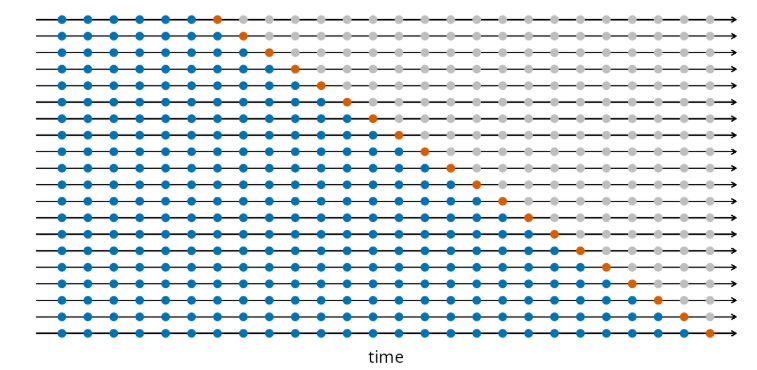

*Source*: Hyndman, R.J. & Athanasopoulos, G. (2021). Forecasting: Principles and Practice (3rd ed). Section 5.10. [https://otexts.com/fpp3/tscv.html](https://otexts.com/fpp3/tscv.html)


In [65]:
# @title Time series cross-validation pipeline with ensemble feature selection
def time_series_pipeline(X, y, model_fn, h, n_splits=5, top_k_ratio=0.25):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    all_scores = {}

    lagged_col = f'ret_lag_{h}'
    if lagged_col not in X.columns:
        raise ValueError(f"Missing lagged return feature: {lagged_col}")

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        print(f"\nFold {fold + 1}/{n_splits}")
        all_scores[fold] = {}

        # Split
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Feature selection
        method_sets = multi_method_selection(X_train, y_train, top_k_ratio)

        print("Selected feature sets:")
        for n in range(0, 7):
            if n == 0:
                selected = list(X.columns)
                print(f"  Selected(0): using all {len(selected)} features")
            else:
                selected = selected_n(method_sets, n)
                print(f"  Selected({n}): {len(selected)} features", end="")
                if selected:
                    print(f" including {', '.join(selected)}")
                else:
                    print()
                    print("    Skipped: No features selected.")
                    all_scores[fold][n] = np.nan
                    continue

            # MLP model
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('model', model_fn(input_dim=len(selected)))
            ])
            pipe.fit(X_train[selected], y_train)
            y_pred = pipe.predict(X_test[selected])
            rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred))

            # Naive: r̂ = 0
            y_naive = np.zeros_like(y_test)
            rmse_naive = np.sqrt(mean_squared_error(y_test, y_naive))

            # Persistence: r̂_t = r_{t−h}, aligned with y_test index
            y_persistent = X_test.loc[y_test.index, lagged_col]
            rmse_persistent = np.sqrt(mean_squared_error(y_test, y_persistent))

            print(f"    MLP RMSE: {rmse_mlp:.4f} | Naive: {rmse_naive:.4f} | Persistent: {rmse_persistent:.4f}")
            all_scores[fold][n] = {
                'MLP': rmse_mlp,
                'Naive': rmse_naive,
                'Persistent': rmse_persistent
            }

    return all_scores


Our model can be written as:
$$r_t^{(h)} = f(X_{t - h}) + \varepsilon_t$$
where:
* $r_t^{(h)} = \log\left( \frac{P_{t+h}}{P_t} \right)$ is the cumulative log return over the next $h$ days; $P_t$ is the closing price at time $t$.
* $X_{t - h}$ is the vector of predictors observed at time $t - h$.
* $f(\cdot)$ is the forecasting function (i.e., MLP in our case).
* $\varepsilon_t$ is the forecast error.

It’s worth emphasizing again that we are predicting the cumulative return over the next $h$ days, not the return on a single future day. This definition makes our forecasting exercise more relevant for investors' decision over defined holding periods.

| Horizon | Use case                                    |
| ------- | ------------------------------------------- |
| **1 day**   | Intraday/next-day signal, short-term alpha  |
| **2–3 days** | Tactical momentum, mean reversion windows   |
| **5 days**   | 1-week outlook (standard for swing trading) |
| **10 days**  | 2-week view, momentum or volatility decay   |
| **20 days**  | \~1 month, mid-term risk/return signal      |


The model performance is evaluated against three baselines: the model using all features, and two benchmark models—Naive and Persistent.

- **Naive Return**: Assumes the return is always zero (Beck et al. 2025): ${r}_t^{(h)} = 0$.

- **Persistent Return**: Assumes the best forecast is the last observed return: $\hat{r}_t^{(h)} = r_{t-h}^{(h)}$

Consider two evaluation strategies: (i) applying the same rolling forecasting origin to both the MLP and benchmark models, averaging performance metrics across folds for robust comparison; or (ii) using a single train-test split, training all models on historical data and evaluating on a fixed future window. While the second approach better simulates real-world deployment, we will adopt the first to ensure consistency and fairness in model comparison. The evaluation metric is **RMSE**, computed across rolling-origin cross-validation folds.

In [66]:
# @title Cross-validation for different forecast horizons
forecast_horizons = [1, 2, 3, 5, 10, 20]  # in days

results = {}

for h in forecast_horizons:
    print(f"\n--- Forecasting {h}-day ahead return ---")

    # Define target: h-day cumulative log return
    df['ret'] = np.log(df['close'] / df['close'].shift(h))
    y = df['ret'].dropna()

    # Use lagged features aligned with forecast horizon
    X = df.shift(h).add_suffix(f'_lag_{h}').copy()

    # Drop NA and align
    X.dropna(inplace=True)
    y = y.loc[X.index]

    print(f'X shape: {X.shape}')
    print(f'y shape: {y.shape}')

    # Run pipeline
    all_scores = time_series_pipeline(X, y, model_fn, h, n_splits=5, top_k_ratio=0.25)
    results[h] = all_scores



--- Forecasting 1-day ahead return ---
X shape: (4228, 103)
y shape: (4228,)

Fold 1/5
Selected feature sets:
  Selected(0): using all 103 features
    MLP RMSE: 0.1373 | Naive: 0.0228 | Persistent: 0.0312
  Selected(1): 86 features including CDLSHORTLINE_lag_1, CDLHANGINGMAN_lag_1, CDLMATCHINGLOW_lag_1, CDLBELTHOLD_lag_1, CDLHIGHWAVE_lag_1, CDLHAMMER_lag_1, CDLINVERTEDHAMMER_lag_1, CDLGRAVESTONEDOJI_lag_1, CDLSPINNINGTOP_lag_1, CDLHIKKAKE_lag_1, CDLRICKSHAWMAN_lag_1, CDLSEPARATINGLINES_lag_1, CDLHARAMICROSS_lag_1, STOCHF_0_lag_1, ret_lag_1, MIDPRICE_lag_1, CDLMARUBOZU_lag_1, PLUS_DI_lag_1, HT_TRENDMODE_lag_1, STOCHRSI_0_lag_1, TRANGE_lag_1, KAMA_lag_1, CDLDRAGONFLYDOJI_lag_1, CDLTAKURI_lag_1, WILLR_lag_1, AROONOSC_lag_1, ADOSC_lag_1, CDL3OUTSIDE_lag_1, HT_DCPERIOD_lag_1, PPO_lag_1, MACDEXT_2_lag_1, ATR_lag_1, CDLDOJISTAR_lag_1, HT_DCPHASE_lag_1, volume_lag_1, close_lag_1, HT_PHASOR_0_lag_1, CMO_lag_1, ADXR_lag_1, HT_SINE_1_lag_1, MACD_0_lag_1, DX_lag_1, NATR_lag_1, HT_PHASOR_1_lag_1,


--- Evaluating RMSE for 1-day ahead forecast ---


,Selected(0),Selected(1),Selected(2),Selected(3),Selected(4),Selected(5),Selected(6)
Model,,,,,,,
MLP,0.1359,0.1300,0.0605,0.0390,0.0224,0.0223,0.0222
Naive,0.0214,0.0214,0.0214,0.0214,0.0214,0.0218,0.0217
Persistent,0.0294,0.0294,0.0294,0.0294,0.0294,0.0298,0.0297


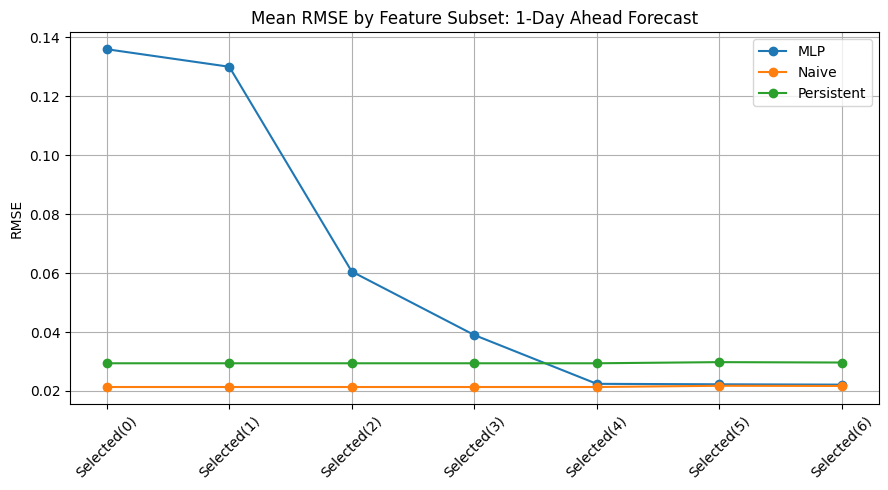


--- Evaluating RMSE for 2-day ahead forecast ---


,Selected(0),Selected(1),Selected(2),Selected(3),Selected(4),Selected(5),Selected(6)
Model,,,,,,,
MLP,0.1647,0.1964,0.1062,0.1183,0.0357,0.0314,0.0310
Naive,0.0310,0.0310,0.0310,0.0310,0.0310,0.0310,0.0311
Persistent,0.0433,0.0433,0.0433,0.0433,0.0433,0.0433,0.0449


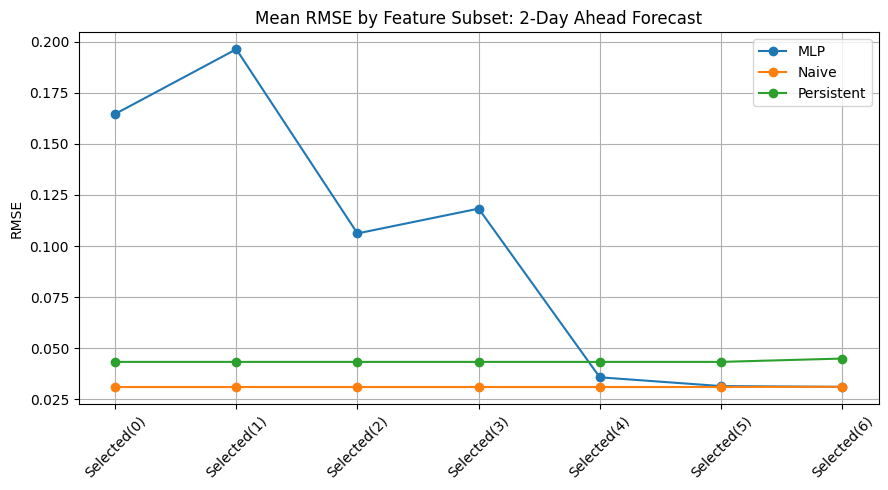


--- Evaluating RMSE for 3-day ahead forecast ---


,Selected(0),Selected(1),Selected(2),Selected(3),Selected(4),Selected(5),Selected(6)
Model,,,,,,,
MLP,0.2214,0.2233,0.1073,0.0854,0.0582,0.0376,0.0370
Naive,0.0383,0.0383,0.0383,0.0383,0.0383,0.0374,0.0357
Persistent,0.0541,0.0541,0.0541,0.0541,0.0541,0.0534,0.0519


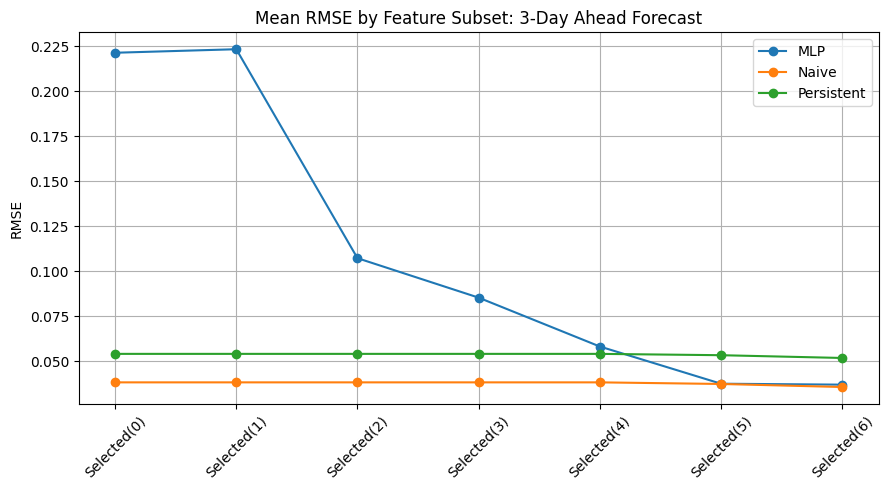


--- Evaluating RMSE for 5-day ahead forecast ---


,Selected(0),Selected(1),Selected(2),Selected(3),Selected(4),Selected(5),Selected(6)
Model,,,,,,,
MLP,0.2051,0.1883,0.1366,0.1230,0.0793,0.0541,NaN
Naive,0.0496,0.0496,0.0496,0.0496,0.0496,0.0496,NaN
Persistent,0.0703,0.0703,0.0703,0.0703,0.0703,0.0703,NaN


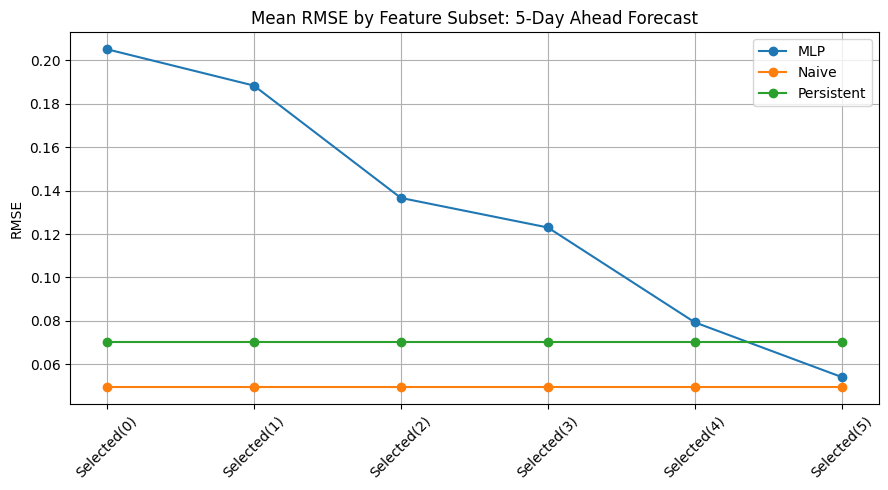


--- Evaluating RMSE for 10-day ahead forecast ---


,Selected(0),Selected(1),Selected(2),Selected(3),Selected(4),Selected(5),Selected(6)
Model,,,,,,,
MLP,0.2379,0.3095,0.2876,0.2282,0.2042,0.0742,NaN
Naive,0.0698,0.0698,0.0698,0.0698,0.0698,0.0698,NaN
Persistent,0.0945,0.0945,0.0945,0.0945,0.0945,0.0945,NaN


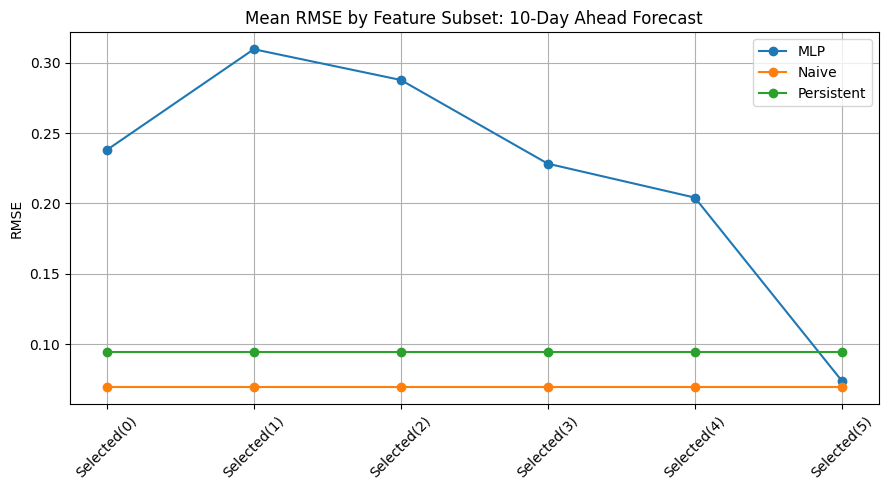


--- Evaluating RMSE for 20-day ahead forecast ---


,Selected(0),Selected(1),Selected(2),Selected(3),Selected(4),Selected(5),Selected(6)
Model,,,,,,,
MLP,0.3817,0.3748,0.3993,0.5153,0.2517,0.1167,0.1195
Naive,0.1026,0.1026,0.1026,0.1026,0.1026,0.1085,0.1043
Persistent,0.1349,0.1349,0.1349,0.1349,0.1349,0.1355,0.1376


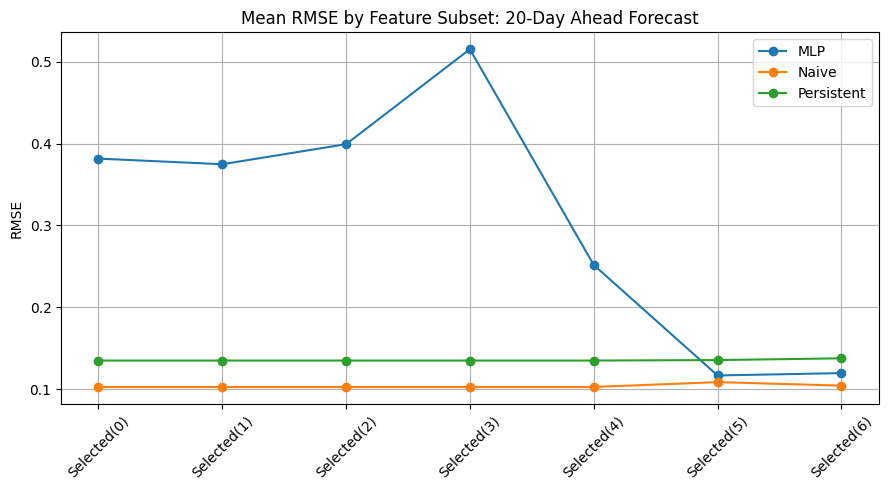

In [70]:
# @title Compute and compare mean RMSE of feature subsets against baseline models
for h, all_scores in results.items():
    print(f"\n--- Evaluating RMSE for {h}-day ahead forecast ---")

    # Prepare nested DataFrame: fold -> Selected(n) -> {MLP, Naive, Persistent}
    nested_df = pd.DataFrame(all_scores).T  # shape: folds x Selected(n), values: dicts

    # Flatten into multi-index: (Selected(n), Model)
    data = []
    for sel_n in nested_df.columns:
        for model in ['MLP', 'Naive', 'Persistent']:
            vals = nested_df[sel_n].apply(lambda x: x.get(model) if isinstance(x, dict) else np.nan)
            data.append((sel_n, model, vals.mean()))

    # Summary table (MLP + baselines)
    mean_rmse = pd.DataFrame(data, columns=['Subset', 'Model', 'RMSE']).pivot(index='Model', columns='Subset', values='RMSE')
    mean_rmse.columns = [f"Selected({i})" for i in mean_rmse.columns]
    flat_summary = mean_rmse.loc[['MLP', 'Naive', 'Persistent']]
    display(flat_summary.round(4))

    # Plot
    df_plot = mean_rmse.T.reset_index().melt(id_vars='index', var_name='Model', value_name='Mean RMSE')
    df_plot = df_plot.rename(columns={'index': 'Feature Subset'})
    df_plot['SortKey'] = df_plot['Feature Subset'].str.extract(r'(\d+)').astype(int)

    df_plot = df_plot.sort_values(['SortKey', 'Model'])

    plt.figure(figsize=(9, 5))
    for model in df_plot['Model'].unique():
        subset = df_plot[df_plot['Model'] == model]
        plt.plot(subset['Feature Subset'], subset['Mean RMSE'], marker='o', label=model)

    plt.title(f"Mean RMSE by Feature Subset: {h}-Day Ahead Forecast")
    plt.ylabel("RMSE")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Key Findings
* **The feature selection ensemble significantly improves the MLP model's performance.** RMSE across all horizons drops substantially as fewer, more relevant features are selected.
* **The inclusion of technical indicators allows the MLP to consistently outperform the Persistent benchmark, which relies solely on the lagged cumulative returns.** This shows that technical indicators can provide meaningful signals for stock price movements beyond what is captured by past returns alone.
* **The MLP comes close but never beats the Naive benchmark.** While RMSE narrows at Selected(5) and Selected(6), the Naive model still holds a slight edge. This outcome reflects the low signal-to-noise ratio typical in financial returns. Most of the time, returns are close to zero.
* Nonetheless, these results are encouraging and suggest several avenues for future development:
 * So far, the model relies solely on technical indicators. Incorporating **fundamental variables or alternative data sources** may provide additional predictive power and improve overall performance.
 * The Naive benchmark generates no actionable signal, as it always assumes the price remains unchanged. We can reframe the task as **a classification problem that forecasts the direction of price movement**. Even if such a model does not outperform on RMSE, its ability to correctly predict price direction can make it more useful than the Naive benchmark.
 * RMSE is heavily influenced by the majority of “quiet” days in the market and tends to underweight the impact of rare, significant price movements. To address this, our model can shift focus from minimizing average prediction error to **capturing tail events and regime changes**.